In [1]:
# install torchvision for kaggle
!apt-get install -y python-dev pkg-config
!apt-get install -y libavformat-dev libavcodec-dev libavdevice-dev libavutil-dev libswscale-dev libswresample-dev libavfilter-dev
!pip install av




pkg-config is already the newest version (0.29.1-0ubuntu2).
python-dev is already the newest version (2.7.15~rc1-1).
python-dev set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 21 not upgraded.



The following additional packages will be installed:
  libavresample-dev libpostproc-dev
The following NEW packages will be installed:
  libavcodec-dev libavdevice-dev libavfilter-dev libavformat-dev
  libavresample-dev libavutil-dev libpostproc-dev libswresample-dev
  libswscale-dev
0 upgraded, 9 newly installed, 0 to remove and 21 not upgraded.
Need to get 7956 kB of archives.
After this operation, 33.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 libavutil-dev amd64 7:3.4.8-0ubuntu0.2 [294 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 libswresample-dev amd64 7:3.4.8-0ubuntu0.2 [68.7 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 libavcodec-dev a

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from tqdm import tqdm
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt

/kaggle/input/drowsiness-batch-dataset-fold2-1/Fold_2_1.csv
/kaggle/input/drowsiness-batch-dataset-fold2-1/__results__.html
/kaggle/input/drowsiness-batch-dataset-fold2-1/__notebook__.ipynb
/kaggle/input/drowsiness-batch-dataset-fold2-1/__output__.json
/kaggle/input/drowsiness-batch-dataset-fold2-1/custom.css
/kaggle/input/drowsiness-dataset-fold3-2/__results__.html
/kaggle/input/drowsiness-dataset-fold3-2/__notebook__.ipynb
/kaggle/input/drowsiness-dataset-fold3-2/__output__.json
/kaggle/input/drowsiness-dataset-fold3-2/custom.css
/kaggle/input/drowsiness-dataset-fold3-2/Fold3_part2/35/5.mp4
/kaggle/input/drowsiness-dataset-fold3-2/Fold3_part2/35/10.mp4
/kaggle/input/drowsiness-dataset-fold3-2/Fold3_part2/35/0.mp4
/kaggle/input/drowsiness-dataset-fold3-2/Fold3_part2/36/5.mp4
/kaggle/input/drowsiness-dataset-fold3-2/Fold3_part2/36/10.mp4
/kaggle/input/drowsiness-dataset-fold3-2/Fold3_part2/36/0.mp4
/kaggle/input/drowsiness-dataset-fold3-2/Fold3_part2/32/5.mp4
/kaggle/input/drowsiness-d

In [3]:
import torchvision

In [4]:
import cv2

def get_video_meta(video_path):
    cap=cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_count = cap.get(cv2.CAP_PROP_FRAME_COUNT)
    duration = frame_count/fps
    return {'fps':fps,'frame_count':frame_count, 'duration':duration }


def get_path(x):
    files = os.listdir(x)
    return list(map(lambda file: os.path.join(x, file), files))

In [5]:
df_path = '../input/drowsiness-batch-dataset-fold1-1/Fold_1_1.csv'
df = pd.read_csv(df_path, index_col = 0)

df_path = '../input/drowsiness-batch-dataset-fold1-2/Fold_1_2.csv'
df0 = pd.read_csv(df_path, index_col = 0)
df = pd.concat([df,df0], ignore_index = True)

df_path = '../input/drowsiness-batch-dataset-fold2-1/Fold_2_1.csv'
df0 = pd.read_csv(df_path, index_col = 0)
df = pd.concat([df,df0], ignore_index = True)

df_path = '../input/fork-of-drowsiness-batch-dataset-fold2-2/Fold_2_2.csv'
df0 = pd.read_csv(df_path, index_col = 0)
df = pd.concat([df,df0], ignore_index = True)

df_path = '../input/drowsiness-batch-dataset-fold3-1/Fold_3_1.csv'
df0 = pd.read_csv(df_path, index_col = 0)
df = pd.concat([df,df0], ignore_index = True)

df_path = '../input/drowsiness-batch-dataset-fold3-2/Fold_3_2.csv'
df0 = pd.read_csv(df_path, index_col = 0)
df = pd.concat([df,df0], ignore_index = True)

In [6]:
test_files = [
    '../input/drowsiness-dataset-fold1-1/Fold1_part1/06/0.mp4',
    '../input/drowsiness-dataset-fold1-1/Fold1_part1/06/10.mp4',
    '../input/drowsiness-dataset-fold1-1/Fold1_part1/06/5.mp4',
    '../input/drowsiness-dataset-fold1-1/Fold1_part1/02/0.mov',
    '../input/drowsiness-dataset-fold1-1/Fold1_part1/02/10.MOV',
    '../input/drowsiness-dataset-fold1-1/Fold1_part1/02/5.MOV'
]

In [7]:
df.head()

,id,frame,file,label,x_min,y_min,x_max,y_max,l_18_x,l_18_y,...,l_63_x,l_63_y,l_64_x,l_64_y,l_65_x,l_65_y,l_66_x,l_66_y,l_67_x,l_67_y
0,0,0,../input/drowsiness-dataset-fold1-1/Fold1_part...,10,267,439,577,749,312,472,...,421,652,451,657,422,655,407,657,391,655
1,0,2,../input/drowsiness-dataset-fold1-1/Fold1_part...,10,267,439,577,749,312,471,...,421,651,452,657,421,655,406,657,391,655
2,0,4,../input/drowsiness-dataset-fold1-1/Fold1_part...,10,267,439,577,749,308,474,...,418,653,450,658,418,657,403,658,388,657
3,0,6,../input/drowsiness-dataset-fold1-1/Fold1_part...,10,267,439,577,749,306,475,...,417,654,448,658,418,656,403,658,388,656
4,0,8,../input/drowsiness-dataset-fold1-1/Fold1_part...,10,267,439,577,749,305,474,...,417,651,448,655,418,654,404,656,389,655


In [8]:
files = df.file.unique()
for file in files :
    print(file)
    df_f = df[df.file == file]
    print(df_f.id.values.max())

../input/drowsiness-dataset-fold1-1/Fold1_part1/05/10.MOV
56
../input/drowsiness-dataset-fold1-1/Fold1_part1/05/0.MOV
57
../input/drowsiness-dataset-fold1-1/Fold1_part1/05/5.MOV
57
../input/drowsiness-dataset-fold1-1/Fold1_part1/06/5.mp4
38
../input/drowsiness-dataset-fold1-1/Fold1_part1/06/10.mp4
32
../input/drowsiness-dataset-fold1-1/Fold1_part1/06/0.mp4
37
../input/drowsiness-dataset-fold1-1/Fold1_part1/02/10.MOV
60
../input/drowsiness-dataset-fold1-1/Fold1_part1/02/0.mov
60
../input/drowsiness-dataset-fold1-1/Fold1_part1/02/5.MOV
60
../input/drowsiness-dataset-fold1-1/Fold1_part1/04/5.mp4
55
../input/drowsiness-dataset-fold1-1/Fold1_part1/04/10.mp4
51
../input/drowsiness-dataset-fold1-1/Fold1_part1/04/0.mp4
48
../input/drowsiness-dataset-fold1-1/Fold1_part1/03/10.mov
61
../input/drowsiness-dataset-fold1-1/Fold1_part1/03/0.MOV
47
../input/drowsiness-dataset-fold1-1/Fold1_part1/03/5.mov
60
../input/drowsiness-dataset-fold1-1/Fold1_part1/01/10.MOV
59
../input/drowsiness-dataset-fold1-

In [9]:
train_df = df[~df.file.isin(test_files)]
test_df = df[df.file.isin(test_files)]

In [10]:
class VideoFrameDataset(torch.utils.data.Dataset):
    def __init__(self,
                 annotation_df: pd.DataFrame,
                 num_segments: int = 3,
                 frames_per_segment: int = 1,
                 transform = None,
                 e2e: bool = False, #if not e2e then crop face
                 jump_frame: int = 1,
                 meta_df = None,
                 file_name = None
                ):
        """
        Paramters:
            annotation_df: DataFrame prepare with the format similar to the dataframe above
            num_segments: number of datapoint per clip
            frames_per_segment: number of frame use in a datapoint
            e2e: 
                if True data used for end to end model / image is not cropped
                if False each frame is cropped to the bounding box of users face
            jump_frame: number of index jump in for frames in the index 
                (e.g: jump_frame=2, dataset[0] will be using clip1 at row with index 0,2,4,6,8 - (in this case frames_per_segment=5)) 
                (e.g: jump_frame=0, dataset[0] will be using clip1 at row with index 0,1,2,3 - (in this case frames_per_segment=4)) 
        
        """
        super(VideoFrameDataset, self).__init__()

        
        
        """
        self.annotation_df_list is contains multiple df
            Each dataframe store annotation detail for 1 clip
        """
        annotation_df_list = []
        meta_dict_list = []
        
        self.e2e = e2e
#         if not self.e2e:
#             annotation_df = resize_keypoints(annotation_df, new_shape = (300,300))
      
        
        for video_path, df in tqdm(annotation_df.groupby('file')):
                annotation_df_list.append(df.sort_values(by=['frame']).reset_index(drop=True))
        
        
        if (not meta_df is None):
            self.meta_df = meta_df
        else:
            for video_path, df in tqdm(annotation_df.groupby('file')):
                dic = {}
                dic['video_path'] = video_path

                #TODO: move this to preprocessing step in which time stamp is calculated during df preparation step
                time_stamps, fps = torchvision.io.read_video_timestamps(video_path, pts_unit='sec')
                temp_time_stamps = time_stamps
                dic['time_stamps'] = time_stamps
                dic['fps'] = fps
                # add dataframe into list variable - reset index of every individual 
                meta_dict_list.append(dic)
                self.meta_df = pd.DataFrame(meta_dict_list)
                self.meta_df.to_pickle(file_name)


        self.annotation_df_list = annotation_df_list
        self.video_num = len(self.annotation_df_list)
        self.num_segments = num_segments

        
        assert frames_per_segment >=1, 'frames_per_segment less then one'
        self.frames_per_segment = frames_per_segment            
        self.jump_frame = jump_frame
        self.landmark_cols = self.get_facial_landmarks(annotation_df) 
        self.transform = transform
        
        
            

        
        
    def __len__(self):
        return self.video_num*self.frames_per_segment
    
    def __getitem__(self, index):
        #check index is not larger than lenght of data
#         assert index < self.__len__()
        row = self.index2row(index)
        
        # declare variable to use
        video_path = row['file'][0]
        dic = self.meta_df[self.meta_df['video_path'] == video_path].iloc[0]
        
        frames = row['frame'].values
        fps = dic['fps']
        
        label = row['label'][0]
        label = self.convert_label(label)
        landmark_columns = row[self.landmark_cols]
        if self.e2e:
            frame = elf.read_specific_frame(frames[0], video_path, dic['time_stamps'])
        else:
            bbox = row[['y_min', 'y_max', 'x_min', 'x_max']].values[0]
            frame = self.read_specific_frame(
                frames[0], 
                video_path, 
                dic['time_stamps'], 
                face_bbox=bbox
            )
            landmark_columns = self.convert_facial_landmark_coordinate(row)
        ################################
        
        # Read frame from video and concat them into 1 tensor
#         video_tensor = torch.cat(video_tensor)
        
        return frame[0], label, landmark_columns.values

    
    
    def read_specific_frame(self, frame, video_path, time_stamps, face_bbox=None, transforms=None):
        """
        Return a specific frame in the video clip
        """
        index = time_stamps[frame]
        start_pts = end_pts = time_stamps[frame]
        vframe, aframe, info = torchvision.io.read_video(
            video_path, 
            start_pts=start_pts, 
            end_pts=end_pts, 
            pts_unit='sec'
        )
        file_type = video_path.split('.')[-1]
        if file_type != 'mp4' :
            vframe = vframe.permute(0,2,1,3)
            vframe = torch.flip(vframe, [2])

        if (not face_bbox is None):
            y_min, y_max, x_min, x_max = face_bbox
            x_min = 0 if x_min < 0 else x_min
            y_min = 0 if y_min < 0 else y_min
            # video is on the in the correct orientation (inverse orientation)
            vframe = vframe[:,y_min:y_max, x_min:x_max, :]
            
            # resize vframe so that all face have the same size
            vframe =  vframe.permute(0,3,1,2)
            vframe = F.interpolate(vframe, (300, 300))
            vframe = vframe.permute(0,2,3,1)        
        return vframe
    
    
    def convert_label(self, input_label):
        label_mapping = {
            0:0,
            5:1,
            10:2
        }
        return label_mapping[input_label]
        
    
    
    def get_facial_landmarks(self, df, combined=True):
        facial_landmarks_x, facial_landmarks_y = [], []
        for i in df.keys():
            if(i.split('_')[0]=='l') and i.split('_')[-1]=='x':
                facial_landmarks_x.append(i)
            elif (i.split('_')[0]=='l') and i.split('_')[-1]=='y':
                facial_landmarks_y.append(i)
        if combined:
            return facial_landmarks_x + facial_landmarks_y
        else:
            return facial_landmarks_x, facial_landmarks_y


    def get_landmark(self, row, landmark_num):
        x,y = row[f"l_{landmark_num}_x", f"l_{landmark_num}_y"].values
        return x,y
    
    def convert_facial_landmark_coordinate(self, row, new_shape=(300,300)):
        df = deepcopy(row)
        x_col, y_col = self.get_facial_landmarks(df, combined=False)
        x_df = df[x_col].sub(df['x_min'], axis=0)
        y_df = df[y_col].sub(df['y_min'], axis=0)
        
        
        face_bbox = df[['x_min', 'y_min', 'x_max', 'y_max']]

        y_scale = (face_bbox['y_max'] - face_bbox['y_min']) / new_shape[0]
        x_scale = (face_bbox['x_max'] - face_bbox['x_min']) / new_shape[1] 
        
        x_df = x_df.divide(x_scale, axis=0)
        y_df = y_df.divide(y_scale, axis=0)
        return pd.DataFrame.join(x_df, y_df)

        
    
    def index2row(self, index):
        """
        self.annotation_df_list is contains multiple df
            Each dataframe store annotation detail for 1 clip
            This function convert index used by pytorch dataset into the rows annotation dataframe
        """
        
        
        video_index = index % self.video_num
        df = self.annotation_df_list[video_index]
        row_index = index//self.video_num * (len(df) // self.num_segments)
        
        #careful with case of data point at the end of the video clip        
        rows_index = []
        for i in range(self.frames_per_segment):
            rows_index.append(row_index+(i*self.jump_frame))
            # frame jump to too far ahead in video, simply get datapoint as a list of index [-self.frames_per_segment:]
            if (df.index.max() < max(rows_index)):
                return df.iloc[-self.frames_per_segment:].reset_index(drop=True)
        return df.iloc[rows_index].reset_index(drop=True)

        

In [11]:
def get_facial_landmarks(df, combined=True):
        facial_landmarks_x, facial_landmarks_y = [], []
        for i in df.keys():
            if(i.split('_')[0]=='l') and i.split('_')[-1]=='x':
                facial_landmarks_x.append(i)
            elif (i.split('_')[0]=='l') and i.split('_')[-1]=='y':
                facial_landmarks_y.append(i)
        if combined:
            return facial_landmarks_x + facial_landmarks_y
        else:
            return facial_landmarks_x, facial_landmarks_y

def resize_keypoints(df, new_shape = (300,300)):
    """
    - Input:
        1. Tuple of original data shape
        2. Tuple of key_points data
        3. Tuple of desired shape.
    - Output:
        1. A tuple of resized key_points
    """
    facial_landmarks_x, facial_landmarks_y = get_facial_landmarks(df, combined=False)
    face_bbox = df[['x_min', 'y_min', 'x_max', 'y_max']]
#     print(  x_min, y_min, x_max, y_max )
#     print(df)
    
    
    # Scalling factor
#     print((face_bbox['y_max'] - face_bbox['y_min']).values)
#     print(face_bbox['x_max'] - face_bbox['x_min'].values)
        
    y_scale = new_shape[0] / (face_bbox['y_max'] - face_bbox['y_min'])
    x_scale = new_shape[1] / (face_bbox['x_max'] - face_bbox['x_min']) 
#     df[facial_landmarks_x] = df[facial_landmarks_x] / x_scale
#     df[facial_landmarks_y] = df[facial_landmarks_y] / y_scale
    
    return df

In [12]:
from copy import deepcopy 

train_dataset = VideoFrameDataset(
    annotation_df = train_df,
    num_segments = 50,
    frames_per_segment = 10,
    transform = None,
    jump_frame = 1,
    e2e = False,
    meta_df = None,
    file_name = 'meta_train.pkl'
)
test_dataset = VideoFrameDataset(
    annotation_df = test_df,
    num_segments = 50,
    frames_per_segment = 10,
    transform = None,
    jump_frame = 1,
    e2e = False,
    meta_df = None,
    file_name = 'meta_test.pkl'
)

trainloader = DataLoader(train_dataset, batch_size=50, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=30, shuffle=True)

100%|██████████| 6/6 [20:40<00:00, 206.67s/it]


In [13]:
def generate_optical_flow(batch_landmarks) :
    b, l, s = batch_landmarks.shape
    optical_flow = np.zeros((b,2*l-2,300,300))
    for i_b in range(b) :
        landmarks = batch_landmarks[i_b]
        dx = np.zeros((l-1,300,300), dtype = np.int8)
        dy = np.zeros((l-1,300,300), dtype = np.int8)
        diff = (landmarks[1:] - landmarks[:-1]) * 3
        for i in range(0, l-1) :
            coor = landmarks[i].reshape(2,-1).T
            d = diff[i].reshape(2,-1).T
            for j in range(0, len(coor)) :
                x = int(coor[j][0])
                y = int(coor[j][1])
                x = 0 if x < 0 else x
                y = 0 if y < 0 else y
                y = 299 if y > 299 else y
                x = 299 if x > 299 else x
                dx[i][x][y] = int(d[j][0])
                dy[i][x][y] = int(d[j][1])
            optical_flow[i_b,:l-1,:,:] = dx
            optical_flow[i_b,l-1:,:,:] = dx
    return optical_flow

In [14]:
from torchvision import models
from torch import nn, optim
from torch.nn import functional as F

In [15]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [16]:
spatial_model = models.resnet101(pretrained = True)

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/hub/checkpoints/resnet101-5d3b4d8f.pth


  0%|          | 0.00/170M [00:00<?, ?B/s]

In [17]:
spatial_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [18]:
spatial_model.fc = nn.Linear(2048, 3, bias = True)
for params in spatial_model.parameters() :
    params.requires_grad = False
    
spatial_model.fc.weight.requires_grad = True
spatial_model.fc.bias.requires_grad = True

adam_spatial = optim.Adam(
    filter(lambda p : p.requires_grad, spatial_model.parameters()), 
    lr=1e-4
)
spatial_model = spatial_model.to(device)

In [19]:
from torchvision import transforms

transformation = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean = [0.485, 0.456, 0.406],
        std = [0.229, 0.224, 0.225]
    )
])

In [20]:
epochs = 5
train_losses = []
train_acc = []
test_losses = []
test_acc = []
loss_func = nn.CrossEntropyLoss()
for e in range(epochs) :
    for data in tqdm(trainloader) :
        frames, labels, landmarks = data
        frames = frames.float()
        frame = frame.permute(0,3,1,2).to(device)
        frame = transformation(frame)
        labels = labels.long().to(device)
        adam_spatial.zero_grad()
        out = spatial_model(frames)
        out = F.softmax(out, dim=1)
        loss = loss_func(out, label)
        loss.backward()
        adam_spatial.step()
        train_losses.append(loss.item())
        with torch.no_grad() :
            spatial_pred = out.argmax(axis=1)
            train_acc.append(torch.sum(spatial_pred == label)/len(label))
            test_loss = 0.0
            test_accuracy = 0.0
            for data in testloader :
                frames, labels, landmarks = data
                frames = frames.float()
                frame = frame.permute(0,3,1,2).to(device)
                frame = transformation(frame)
                labels = labels.long().to(device)
                adam_spatial.zero_grad()
                out = spatial_model(frames)
                out = F.softmax(out, dim=1)
                loss = loss_func(out, label)
                test_loss += loss.item()
                spatial_pred = out.argmax(axis=1) 
                test_accuracy += torch.sum(spatial_pred == label)/len(label)
            test_losses.append(test_loss/len(testloader))
            test_acc.append(test_accuracy/len(testloader))

  0%|          | 0/21 [00:01<?, ?it/s]


KeyError: 101

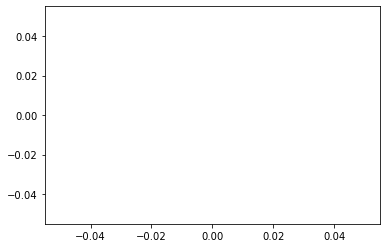

In [21]:
plt.plot(range(len(train_losses)),train_losses)
plt.show()

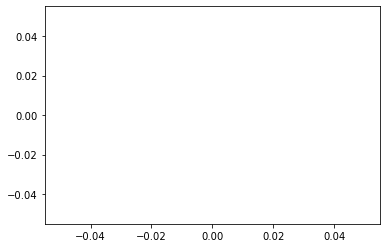

In [22]:
plt.plot(range(len(test_losses)),test_losses)
plt.show()

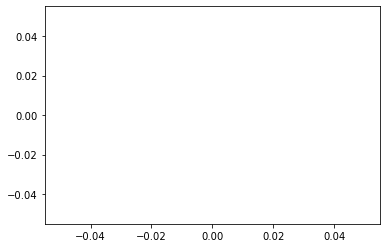

In [23]:
plt.plot(range(len(train_acc)),train_acc)
plt.show()

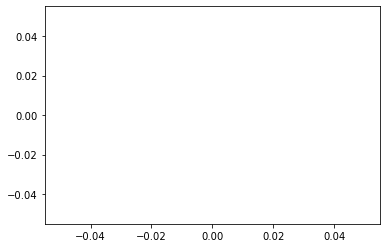

In [24]:
plt.plot(range(len(test_acc)),test_acc)
plt.show()

In [25]:
# class TemporalModel(nn.Module) :
#     def __init__(self, in_channels) :
#         super(TemporalModel, self).__init__()
#         self.conv1 = nn.Conv2d(
#             in_channels = in_channels, 
#             out_channels = 96,
#             kernel_size = 7,
#             stride = 2
#         )
#         self.norm1 = nn.BatchNorm2d(96)
#         self.conv2 = nn.Conv2d(
#             in_channels = 96,
#             out_channels = 256,
#             kernel_size = 5,
#             stride = 2
#         )
#         self.norm2 = nn.BatchNorm2d(256)
#         self.conv3 = nn.Conv2d(
#             in_channels = 256,
#             out_channels = 512,
#             kernel_size = 3,
#             stride = 1
#         )
#         self.norm3 = nn.BatchNorm2d(512)
#         self.conv4 = nn.Conv2d(
#             in_channels = 512,
#             out_channels = 512,
#             kernel_size = 3,
#             stride = 1
#         )
#         self.norm4 = nn.BatchNorm2d(512)
#         self.conv5 = nn.Conv2d(
#             in_channels = 512,
#             out_channels = 512,
#             kernel_size = 3,
#             stride = 1
#         )
#         self.fc1 = nn.Linear(12800, 4096)
#         self.fc2 = nn.Linear(4096, 2048)
#         self.fc3 = nn.Linear(2048, 3)
    
#     def forward(self, x) :
#         x = self.conv1(x)
#         x = self.norm1(x)
#         x = F.relu(x)
#         x = F.max_pool2d(x,(2,2))
#         x = self.conv2(x)
#         x = self.norm2(x)
#         x = F.relu(x)
#         x = F.max_pool2d(x,(2,2))
#         x = self.conv3(x)
#         x = F.relu(x)
#         x = self.conv4(x)
#         x = F.relu(x)
#         x = self.conv5(x)
#         x = F.relu(x)
#         x = F.max_pool2d(x,(2,2))
#         x = x.view(x.shape[0], -1)
#         x = self.fc1(x)
#         x = F.relu(x)
#         x = F.dropout(x, 0.2)
#         x = self.fc2(x)
#         x = F.relu(x)
#         x = F.dropout(x, 0.2)
#         x = self.fc3(x)
#         x = F.softmax(x, dim=1)
#         return x

In [26]:
# def train_2_stream(spatial, temporal, optim_spatial, optim_temporal, epochs=30) :
#     '''
    
#     '''
#     train_loss = []
#     test_loss = []
#     train_acc = []
#     test_acc = []
#     train_recall = []
#     test_recall = []
#     loss_func = nn.CrossEntropyLoss()
    
#     for e in range(epochs) :
#         optim_spatial.zero_grad() 
#         optim_temporal.zero_grad()
#         running_loss = [0.0, 0.0]
#         for data in tqdm(trainloader) :
#             frame, label, landmarks = data
#             frame = frame.float()
#             frame = frame.permute(0,3,1,2).to(device)
#             label = label.long().to(device)
#             optical_flow = generate_optical_flow(landmarks)
#             optical_flow = torch.Tensor(optical_flow).to(device)
            
#             spatial_out = spatial(frame)
#             spatial_out = F.softmax(spatial_out, dim=1)
#             temporal_out = temporal(optical_flow)
#             spatial_loss = loss_func(spatial_out, label)
#             temporal_loss = loss_func(temporal_out, label)
            
#             spatial_loss.backward()
#             temporal_loss.backward()
#             optim_spatial.step()
#             optim_temporal.step()
            
#             running_loss[0] += spatial_loss.item()
#             running_loss[1] += temporal_loss.item()
#         train_loss.append(running_loss)
        
#         running_loss = [0.0, 0.0]
#         count = 0
#         acc = [[], []]
#         with torch.no_grad() :
#             for data in tqdm(testloader) :
#                 frame, label, landmarks = data
#                 label = label.long().to(device)
#                 frame = frame.float().to(device)
#                 frame = frame.permute(0,3,1,2)
#                 optical_flow = generate_optical_flow(landmarks)
#                 optical_flow = torch.Tensor(optical_flow).to(device)

#                 spatial_out = spatial(frame)
#                 spatial_out = F.softmax(spatial_out, dim=1)
#                 temporal_out = temporal(optical_flow)

#                 spatial_loss = loss_func(spatial_out, label)
#                 temporal_loss = loss_func(temporal_out, label)

#                 running_loss[0] += spatial_loss.item()
#                 running_loss[1] += temporal_loss.item()
                
#                 spatial_pred = spatial_out.argmax(axis=1)
#                 temporal_pred = temporal_out.argmax(axis=1)
#                 acc[0].append(torch.sum(spatial_pred == label)/len(label)) 
#                 acc[1].append(torch.sum(temporal_pred == label)/len(label))
#         acc0 = torch.mean(torch.Tensor(acc[0]))
#         acc1 = torch.mean(torch.Tensor(acc[1]))
#         test_acc.append([acc0, acc1])
#         test_loss.append(running_loss)
#     return train_loss, test_acc, test_loss

In [27]:
# temporal = TemporalModel(118)
# adam_temporal = optim.Adam(temporal.parameters(), lr=1e-4)

In [28]:
# temporal = temporal.to(device)

In [29]:
# train_loss, test_acc, test_loss = train_2_stream(spatial_model, temporal, adam_spatial, adam_temporal, epochs=10)

In [30]:
# torch.save(temporal, './temporal.pt')
torch.save(spatial_model , './spatial.pt')

In [31]:
# torch.save(torch.Tensor(train_loss), './trainloss.pt')
# torch.save(torch.Tensor(test_loss), './testloss.pt')
# torch.save(torch.Tensor(test_acc), './testacc.pt')